<a href="https://colab.research.google.com/github/fjadidi2001/Cyber-Attack-Detection/blob/main/Analyzing_and_improving_user_experience_on_educational_websites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'predict-online-course-engagement-dataset' dataset.
Dataset Path: /kaggle/input/predict-online-course-engagement-dataset

STEP 1: EXPLORATORY DATA ANALYSIS

Dataset Shape: (9000, 9)
Target Distribution:
CourseCompletion
0    5432
1    3568
Name: count, dtype: int64
Target Balance: 39.64% completed


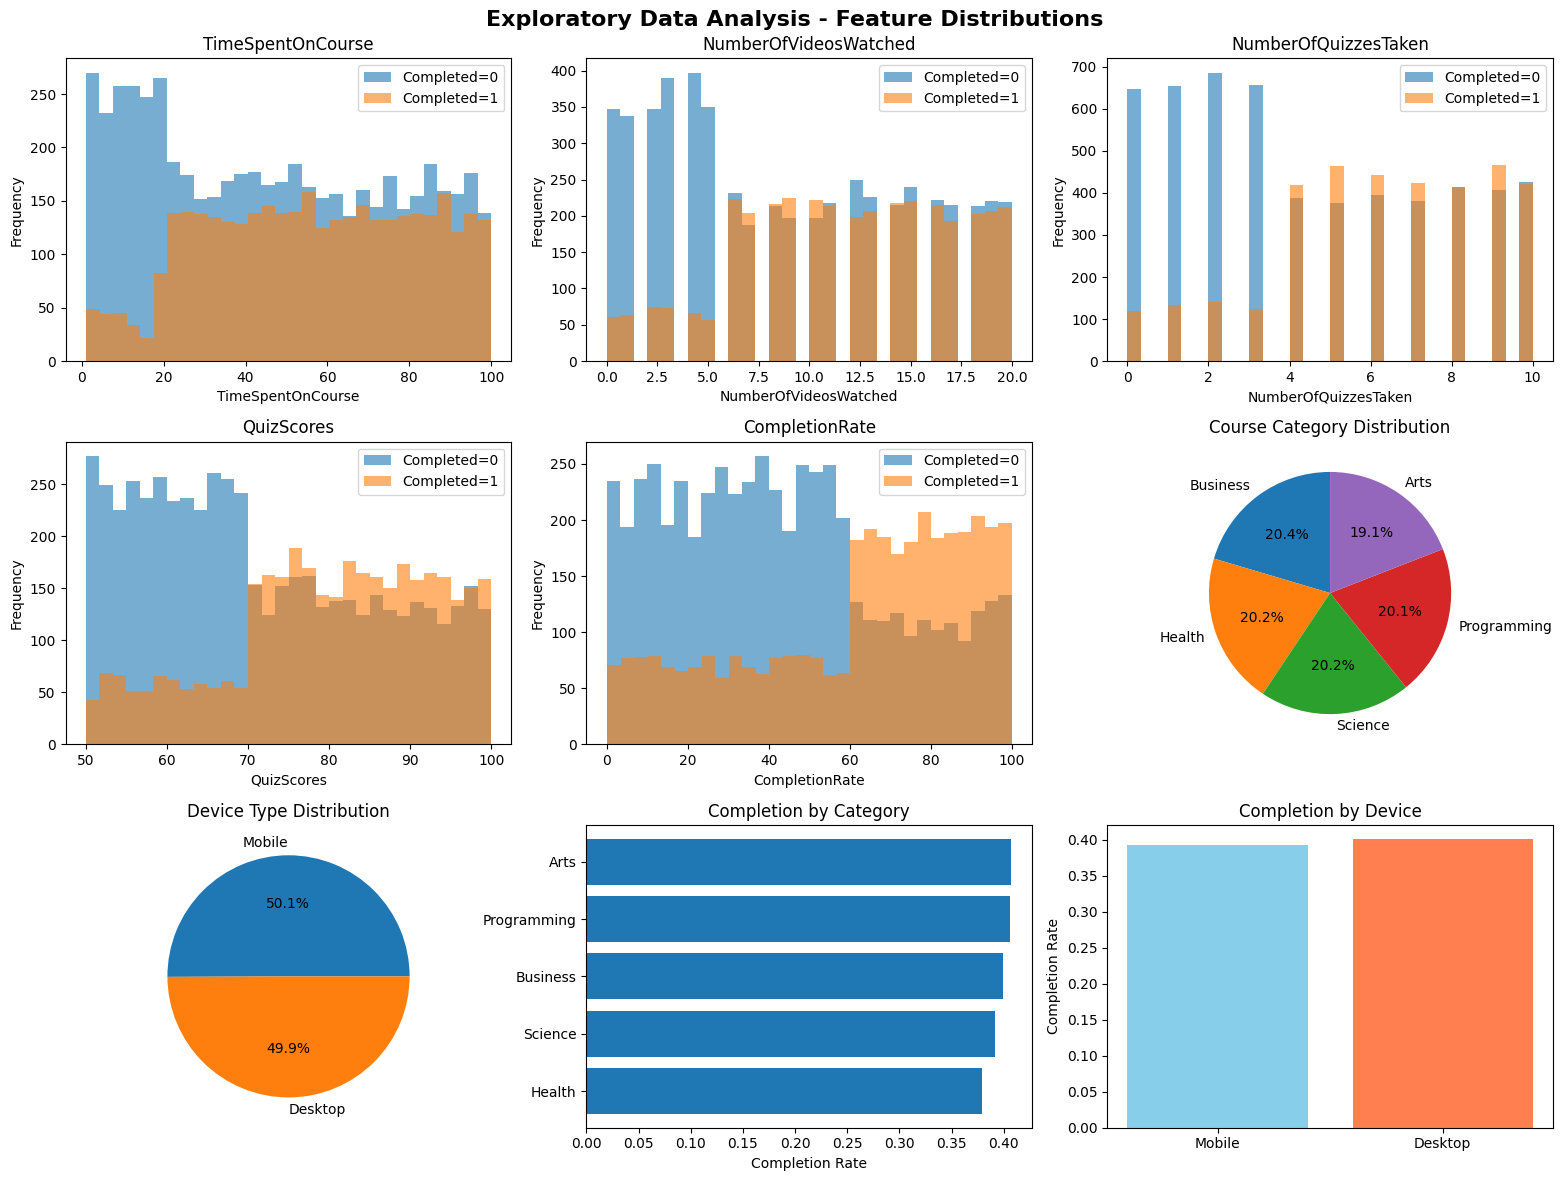

✓ Saved: eda_distributions.png


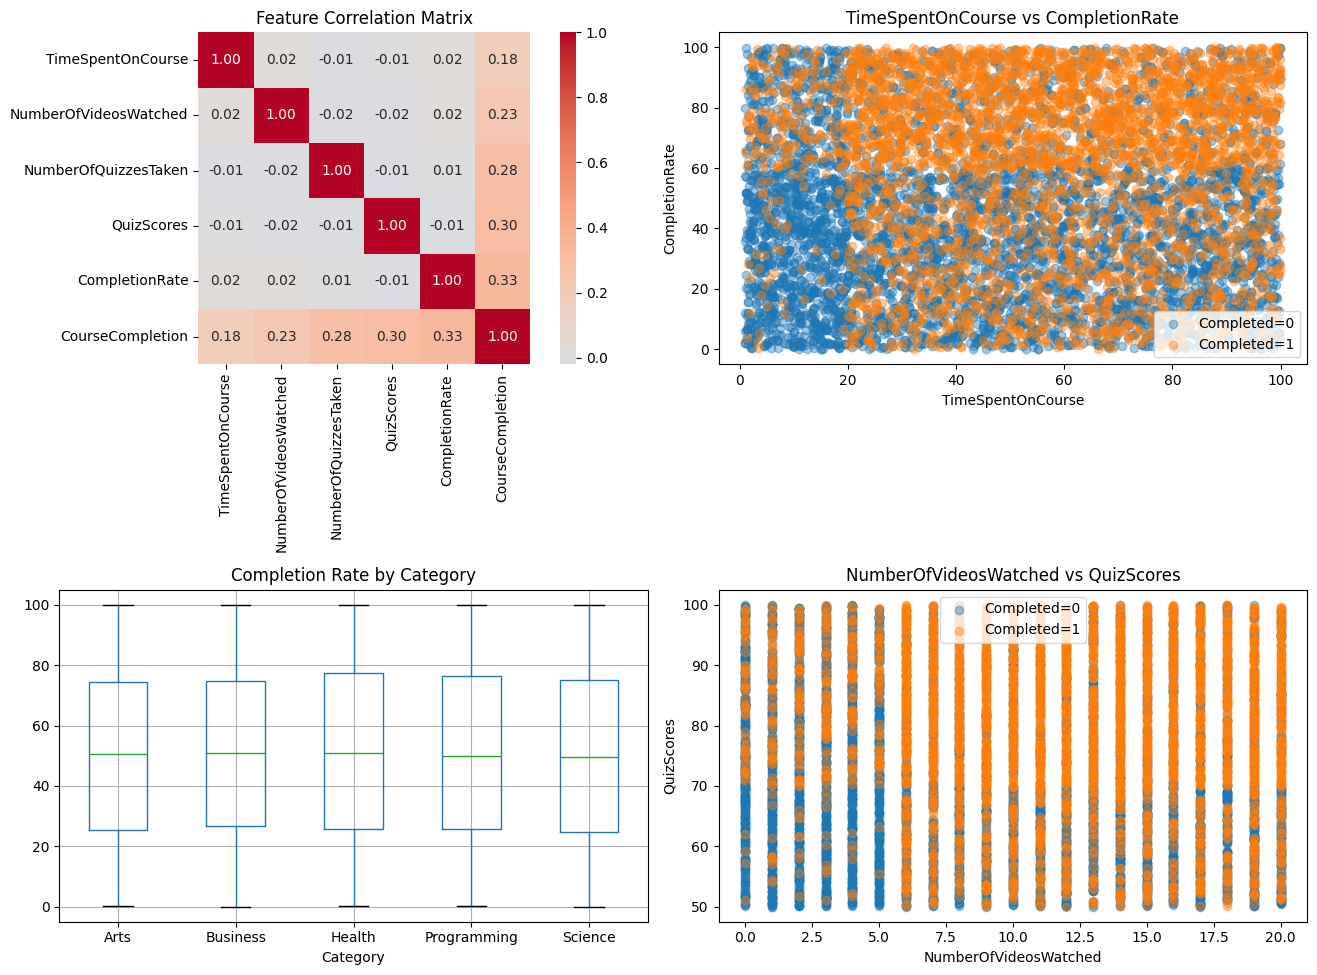

✓ Saved: eda_advanced.png

STEP 2: FEATURE ENGINEERING & PREPROCESSING

New Features Created: ['EngagementScore', 'QuizPerformance', 'VideoEngagement', 'QuizDensity', 'AvgTimePerVideo']
Encoded Categories: ['Arts', 'Business', 'Health', 'Programming', 'Science']


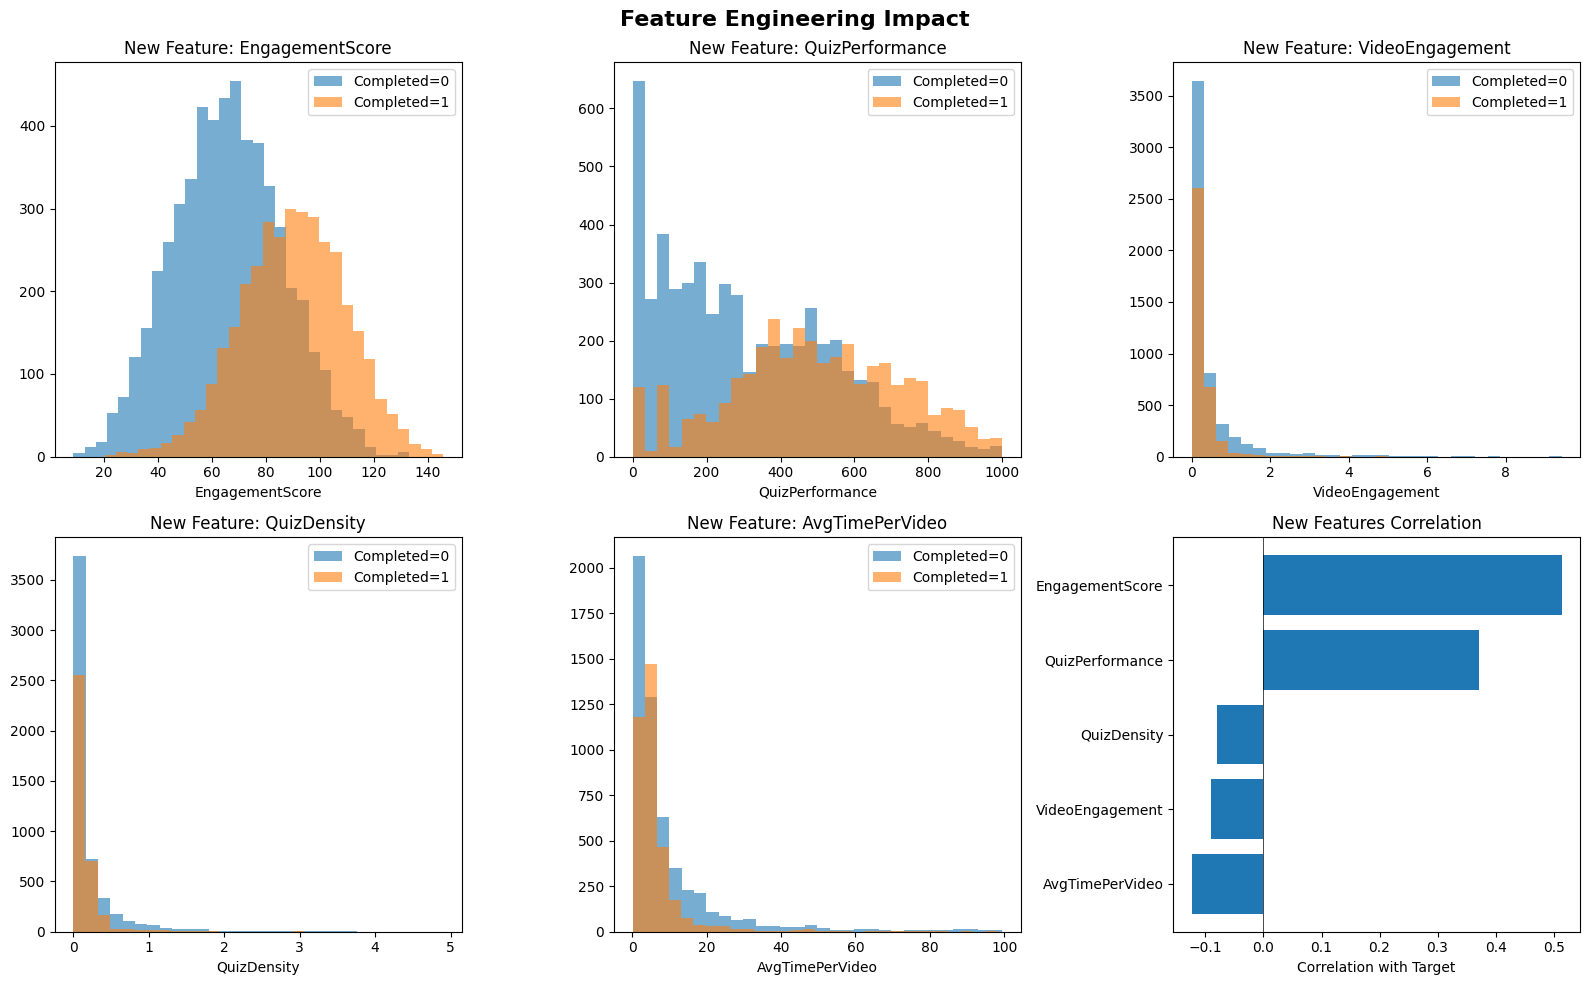

✓ Saved: preprocessing.png

STEP 3: MODEL TRAINING WITH HYPERPARAMETER TUNING

Training RandomForest...
  Train Accuracy: 0.9615
  Test Accuracy: 0.9539
  CV Score: 0.9593 (+/- 0.0049)
  AUC Score: 0.9549

Training GradientBoosting...
  Train Accuracy: 0.9661
  Test Accuracy: 0.9550
  CV Score: 0.9618 (+/- 0.0026)
  AUC Score: 0.9555

Training XGBoost...
  Train Accuracy: 0.9613
  Test Accuracy: 0.9517
  CV Score: 0.9622 (+/- 0.0035)
  AUC Score: 0.9547

✓ Best Model: GradientBoosting (AUC: 0.9555)


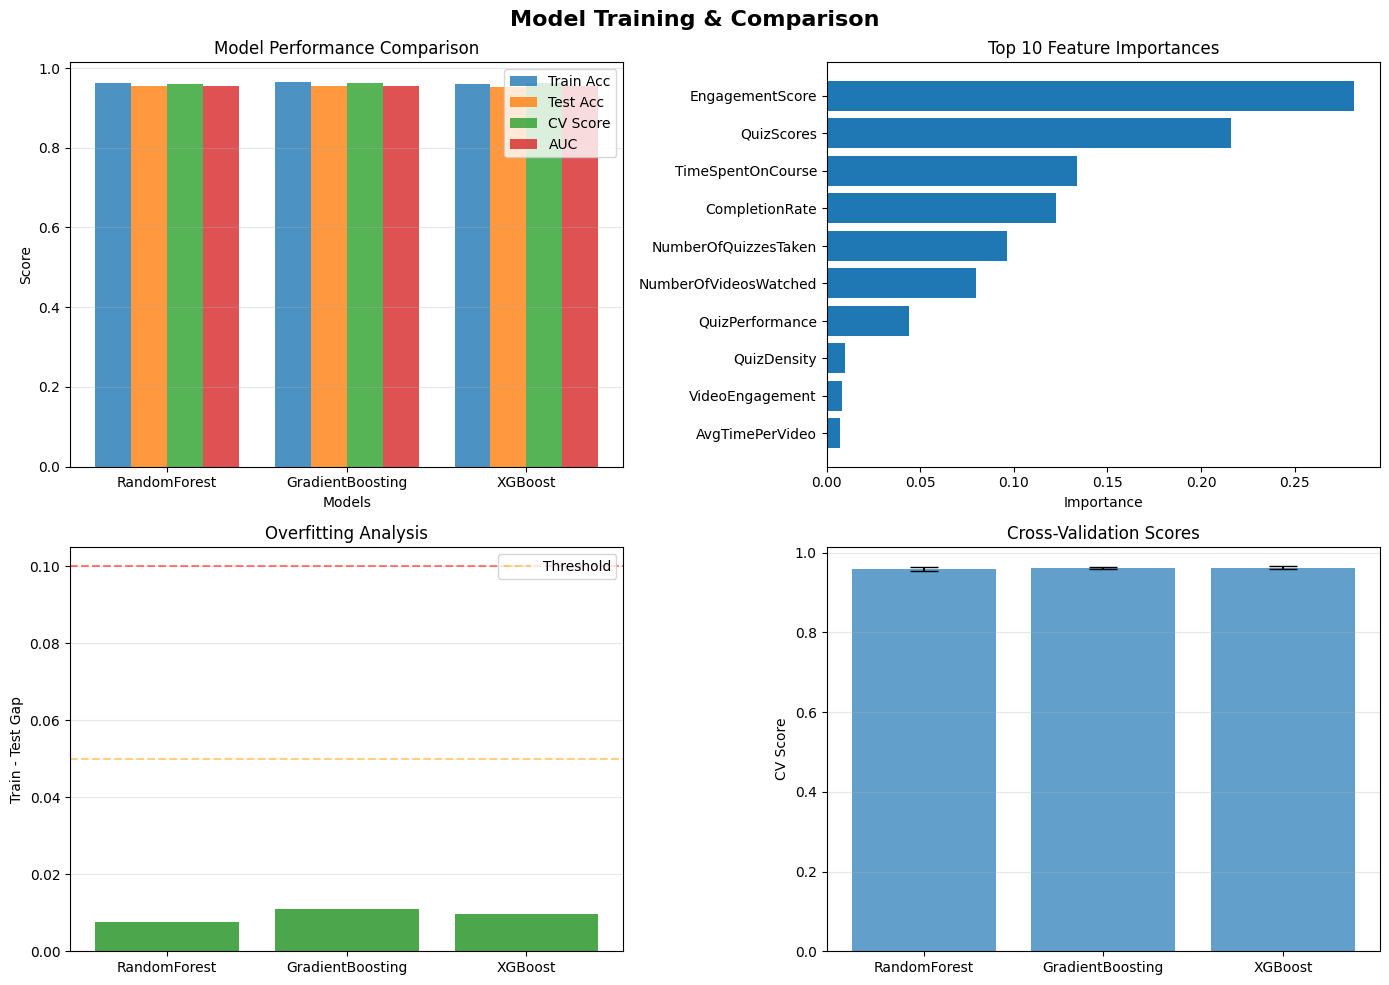

✓ Saved: model_training.png

STEP 4: POST-PROCESSING & PREDICTION ANALYSIS

Prediction Accuracy: 0.9550
Average Confidence: 0.9453

Error Distribution:
Error_Type
Correct           1719
False Negative      49
False Positive      32
Name: count, dtype: int64


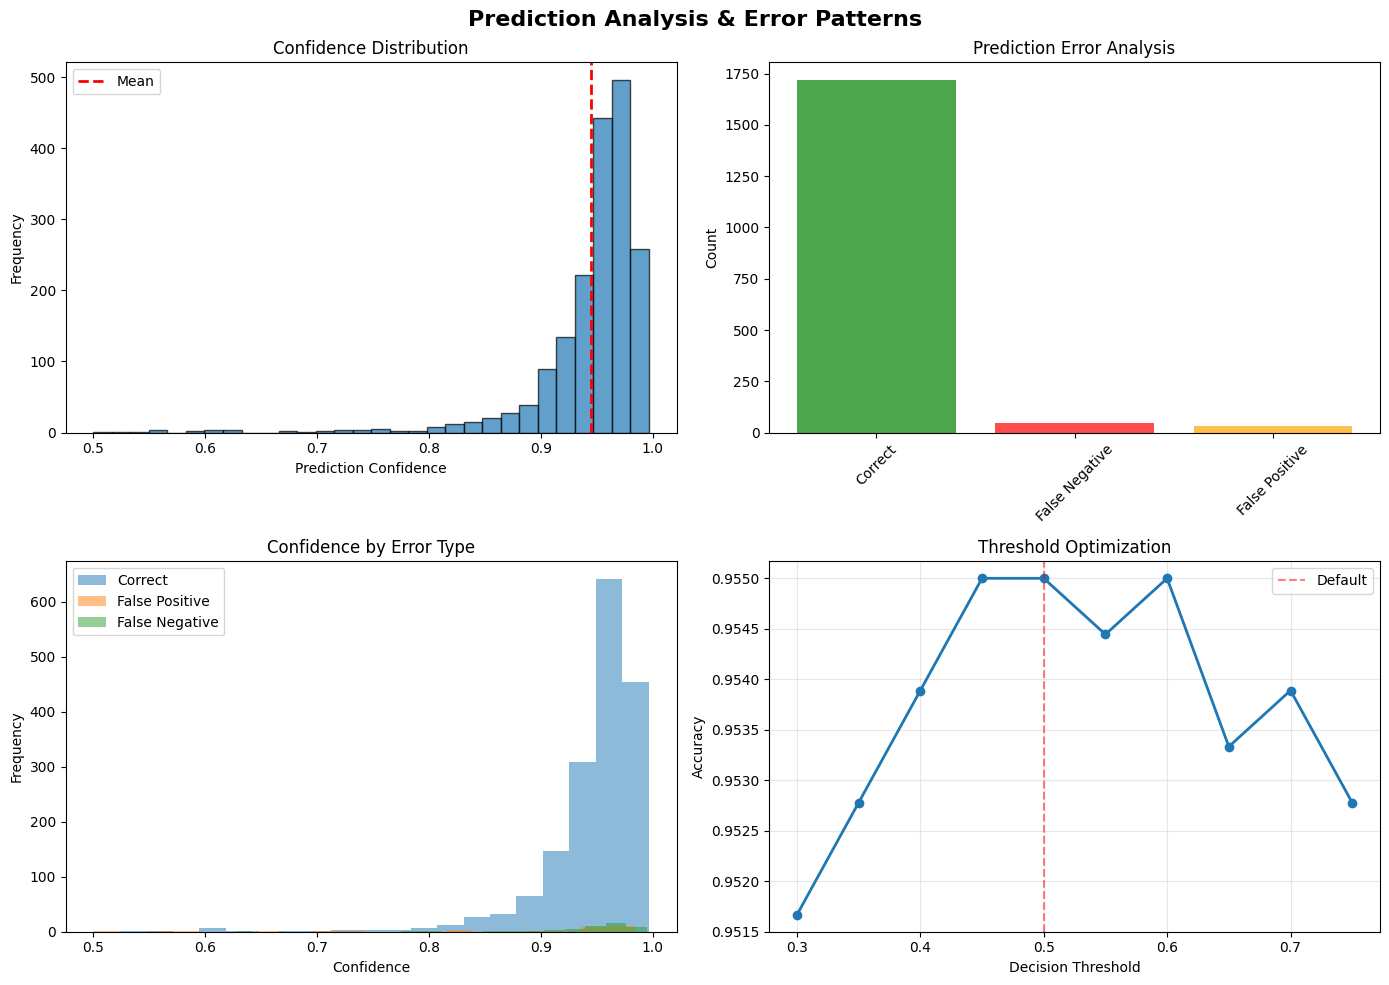

✓ Saved: post_processing.png

STEP 5: COMPREHENSIVE EVALUATION

Classification Metrics:
Accuracy:  0.9550
Precision: 0.9541
Recall:    0.9314
F1-Score:  0.9426
MCC:       0.9058
AUC-ROC:   0.9555

Detailed Classification Report:
               precision    recall  f1-score   support

Not Completed       0.96      0.97      0.96      1086
    Completed       0.95      0.93      0.94       714

     accuracy                           0.95      1800
    macro avg       0.95      0.95      0.95      1800
 weighted avg       0.95      0.95      0.95      1800



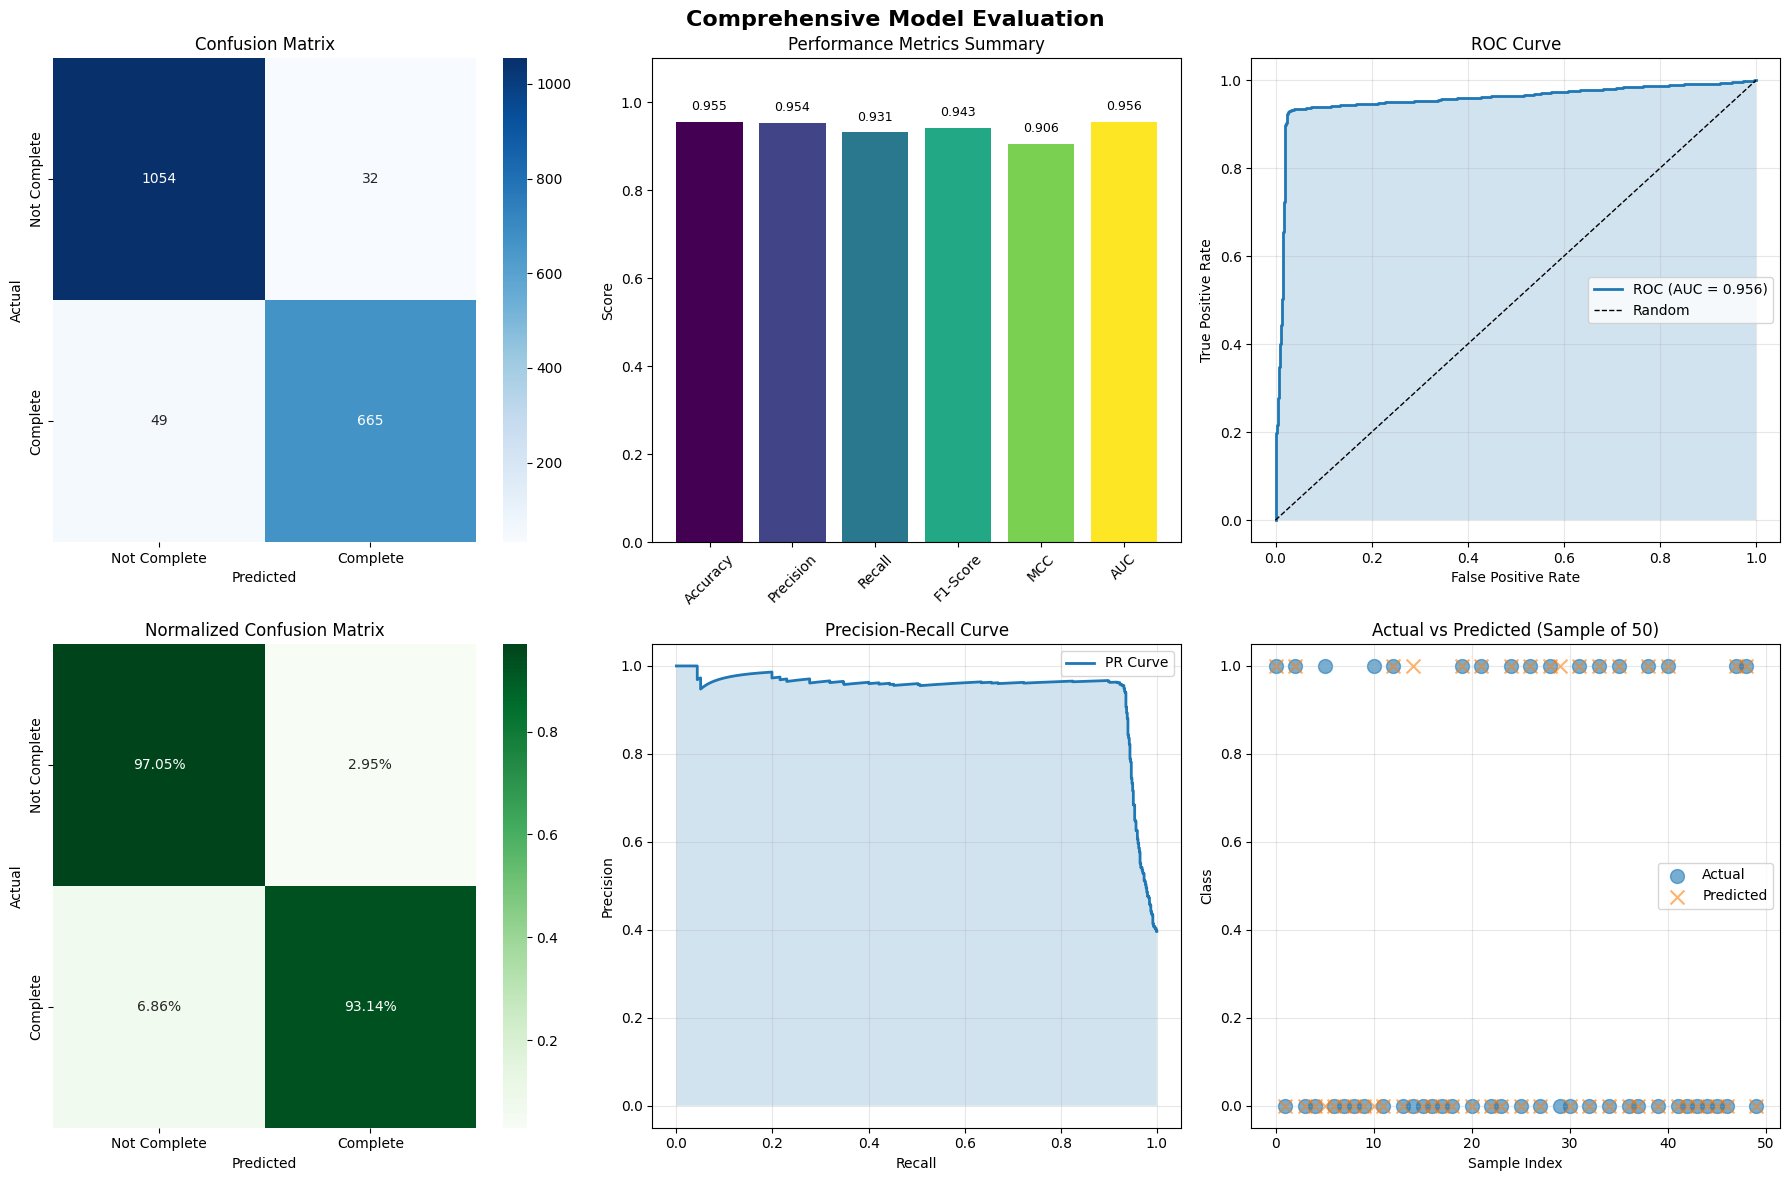

✓ Saved: evaluation.png

FINAL REPORT

Best Model: GradientBoosting
Model Configuration: Balanced with regularization

Performance Summary:
  - Test Accuracy: 0.9550
  - AUC-ROC Score: 0.9555
  - Cross-Val Score: 0.9618 (+/- 0.0026)
  - F1-Score: 0.9426

Dataset Info:
  - Total Samples: 9000
  - Features Used: 12 (including engineered features)
  - Train/Test Split: 7200/1800
  - Class Balance: 39.64% completed

Top 3 Most Important Features:
  - EngagementScore: 0.2815
  - QuizScores: 0.2159
  - TimeSpentOnCourse: 0.1337

✓ Analysis Complete - All Visualizations Saved!


In [3]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("rabieelkharoua/predict-online-course-engagement-dataset")
print("Dataset Path:", path)

df = pd.read_csv(f"{path}/online_course_engagement_data.csv")

print("\n" + "="*80)
print("STEP 1: EXPLORATORY DATA ANALYSIS")
print("="*80)

print(f"\nDataset Shape: {df.shape}")
print(f"Target Distribution:\n{df['CourseCompletion'].value_counts()}")
print(f"Target Balance: {df['CourseCompletion'].mean():.2%} completed")

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Exploratory Data Analysis - Feature Distributions', fontsize=16, fontweight='bold')

numeric_features = ['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken',
                    'QuizScores', 'CompletionRate']

for idx, col in enumerate(numeric_features):
    ax = axes[idx//3, idx%3]
    for completion in [0, 1]:
        data = df[df['CourseCompletion'] == completion][col]
        ax.hist(data, bins=30, alpha=0.6, label=f'Completed={completion}')
    ax.set_title(f'{col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()

axes[1, 2].pie(df['CourseCategory'].value_counts(), labels=df['CourseCategory'].value_counts().index,
               autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Course Category Distribution')

axes[2, 0].pie(df['DeviceType'].value_counts(), labels=['Mobile', 'Desktop'], autopct='%1.1f%%')
axes[2, 0].set_title('Device Type Distribution')

completion_by_category = df.groupby('CourseCategory')['CourseCompletion'].mean().sort_values()
axes[2, 1].barh(completion_by_category.index, completion_by_category.values)
axes[2, 1].set_xlabel('Completion Rate')
axes[2, 1].set_title('Completion by Category')

completion_by_device = df.groupby('DeviceType')['CourseCompletion'].mean()
axes[2, 2].bar(['Mobile', 'Desktop'], completion_by_device.values, color=['skyblue', 'coral'])
axes[2, 2].set_ylabel('Completion Rate')
axes[2, 2].set_title('Completion by Device')

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: eda_distributions.png")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Advanced EDA - Correlations & Relationships', fontsize=16, fontweight='bold')

corr_matrix = df[numeric_features + ['CourseCompletion']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0, 0], square=True)
axes[0, 0].set_title('Feature Correlation Matrix')

scatter_features = [['TimeSpentOnCourse', 'CompletionRate'],
                    ['NumberOfVideosWatched', 'QuizScores']]
for idx, (feat1, feat2) in enumerate(scatter_features):
    ax = axes[idx, 1]
    for completion in [0, 1]:
        data = df[df['CourseCompletion'] == completion]
        ax.scatter(data[feat1], data[feat2], alpha=0.4, label=f'Completed={completion}')
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.set_title(f'{feat1} vs {feat2}')
    ax.legend()

df.boxplot(column='CompletionRate', by='CourseCategory', ax=axes[1, 0])
axes[1, 0].set_title('Completion Rate by Category')
axes[1, 0].set_xlabel('Category')
plt.suptitle('')

plt.tight_layout()
plt.savefig('eda_advanced.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: eda_advanced.png")

print("\n" + "="*80)
print("STEP 2: FEATURE ENGINEERING & PREPROCESSING")
print("="*80)

df_processed = df.copy()

df_processed['EngagementScore'] = (
    df_processed['TimeSpentOnCourse'] * 0.3 +
    df_processed['NumberOfVideosWatched'] * 2 +
    df_processed['NumberOfQuizzesTaken'] * 3 +
    df_processed['CompletionRate'] * 0.5
)

df_processed['QuizPerformance'] = df_processed['QuizScores'] * df_processed['NumberOfQuizzesTaken']
df_processed['VideoEngagement'] = df_processed['NumberOfVideosWatched'] / (df_processed['TimeSpentOnCourse'] + 1)
df_processed['QuizDensity'] = df_processed['NumberOfQuizzesTaken'] / (df_processed['TimeSpentOnCourse'] + 1)
df_processed['AvgTimePerVideo'] = df_processed['TimeSpentOnCourse'] / (df_processed['NumberOfVideosWatched'] + 1)

le_category = LabelEncoder()
df_processed['CourseCategory_encoded'] = le_category.fit_transform(df_processed['CourseCategory'])

print(f"\nNew Features Created: {['EngagementScore', 'QuizPerformance', 'VideoEngagement', 'QuizDensity', 'AvgTimePerVideo']}")
print(f"Encoded Categories: {list(le_category.classes_)}")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Feature Engineering Impact', fontsize=16, fontweight='bold')

new_features = ['EngagementScore', 'QuizPerformance', 'VideoEngagement', 'QuizDensity', 'AvgTimePerVideo']
for idx, feat in enumerate(new_features):
    ax = axes[idx//3, idx%3]
    for completion in [0, 1]:
        data = df_processed[df_processed['CourseCompletion'] == completion][feat]
        ax.hist(data, bins=30, alpha=0.6, label=f'Completed={completion}')
    ax.set_title(f'New Feature: {feat}')
    ax.set_xlabel(feat)
    ax.legend()

feature_importance_preview = df_processed[new_features + ['CourseCompletion']].corr()['CourseCompletion'].drop('CourseCompletion').sort_values()
axes[1, 2].barh(feature_importance_preview.index, feature_importance_preview.values)
axes[1, 2].set_xlabel('Correlation with Target')
axes[1, 2].set_title('New Features Correlation')
axes[1, 2].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('preprocessing.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: preprocessing.png")

print("\n" + "="*80)
print("STEP 3: MODEL TRAINING WITH HYPERPARAMETER TUNING")
print("="*80)

feature_cols = ['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken',
                'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_encoded',
                'EngagementScore', 'QuizPerformance', 'VideoEngagement', 'QuizDensity', 'AvgTimePerVideo']

X = df_processed[feature_cols]
y = df_processed['CourseCompletion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        class_weight='balanced'
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=20,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=5,
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])
    )
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'train': train_score,
        'test': test_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'auc': auc_score,
        'model': model
    }

    print(f"  Train Accuracy: {train_score:.4f}")
    print(f"  Test Accuracy: {test_score:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  AUC Score: {auc_score:.4f}")

best_model_name = max(results, key=lambda x: results[x]['auc'])
best_model = results[best_model_name]['model']
print(f"\n✓ Best Model: {best_model_name} (AUC: {results[best_model_name]['auc']:.4f})")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Training & Comparison', fontsize=16, fontweight='bold')

model_names = list(results.keys())
metrics = ['train', 'test', 'cv_mean', 'auc']
metric_labels = ['Train Acc', 'Test Acc', 'CV Score', 'AUC']

x = np.arange(len(model_names))
width = 0.2

for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    values = [results[m][metric] for m in model_names]
    axes[0, 0].bar(x + i*width, values, width, label=label, alpha=0.8)

axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_xticks(x + width*1.5)
axes[0, 0].set_xticklabels(model_names)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    axes[0, 1].barh(range(len(feature_importance)), feature_importance['importance'])
    axes[0, 1].set_yticks(range(len(feature_importance)))
    axes[0, 1].set_yticklabels(feature_importance['feature'])
    axes[0, 1].set_xlabel('Importance')
    axes[0, 1].set_title('Top 10 Feature Importances')
    axes[0, 1].invert_yaxis()

overfitting = [(results[m]['train'] - results[m]['test']) for m in model_names]
colors = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in overfitting]
axes[1, 0].bar(model_names, overfitting, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Train - Test Gap')
axes[1, 0].set_title('Overfitting Analysis')
axes[1, 0].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Threshold')
axes[1, 0].axhline(y=0.1, color='red', linestyle='--', alpha=0.5)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

cv_means = [results[m]['cv_mean'] for m in model_names]
cv_stds = [results[m]['cv_std'] for m in model_names]
axes[1, 1].bar(model_names, cv_means, yerr=cv_stds, capsize=10, alpha=0.7)
axes[1, 1].set_ylabel('CV Score')
axes[1, 1].set_title('Cross-Validation Scores')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_training.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: model_training.png")

print("\n" + "="*80)
print("STEP 4: POST-PROCESSING & PREDICTION ANALYSIS")
print("="*80)

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)

predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Prob_Incomplete': y_pred_proba[:, 0],
    'Prob_Complete': y_pred_proba[:, 1],
    'Confidence': y_pred_proba.max(axis=1)
})

predictions_df['Correct'] = (predictions_df['Actual'] == predictions_df['Predicted']).astype(int)
predictions_df['Error_Type'] = predictions_df.apply(
    lambda x: 'Correct' if x['Correct'] else ('False Positive' if x['Predicted'] == 1 else 'False Negative'),
    axis=1
)

print(f"\nPrediction Accuracy: {predictions_df['Correct'].mean():.4f}")
print(f"Average Confidence: {predictions_df['Confidence'].mean():.4f}")
print(f"\nError Distribution:")
print(predictions_df['Error_Type'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Prediction Analysis & Error Patterns', fontsize=16, fontweight='bold')

axes[0, 0].hist(predictions_df['Confidence'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(predictions_df['Confidence'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].set_xlabel('Prediction Confidence')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Confidence Distribution')
axes[0, 0].legend()

error_types = predictions_df['Error_Type'].value_counts()
colors_map = {'Correct': 'green', 'False Positive': 'orange', 'False Negative': 'red'}
colors = [colors_map[et] for et in error_types.index]
axes[0, 1].bar(error_types.index, error_types.values, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Prediction Error Analysis')
axes[0, 1].tick_params(axis='x', rotation=45)

for error_type in ['Correct', 'False Positive', 'False Negative']:
    if error_type in predictions_df['Error_Type'].values:
        data = predictions_df[predictions_df['Error_Type'] == error_type]['Confidence']
        axes[1, 0].hist(data, bins=20, alpha=0.5, label=error_type)
axes[1, 0].set_xlabel('Confidence')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Confidence by Error Type')
axes[1, 0].legend()

thresholds = np.arange(0.3, 0.8, 0.05)
accuracies = []
for thresh in thresholds:
    pred_at_thresh = (predictions_df['Prob_Complete'] >= thresh).astype(int)
    acc = (pred_at_thresh == predictions_df['Actual']).mean()
    accuracies.append(acc)

axes[1, 1].plot(thresholds, accuracies, marker='o', linewidth=2)
axes[1, 1].axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Default')
axes[1, 1].set_xlabel('Decision Threshold')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Threshold Optimization')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('post_processing.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: post_processing.png")

print("\n" + "="*80)
print("STEP 5: COMPREHENSIVE EVALUATION")
print("="*80)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print("\nClassification Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")
print(f"AUC-ROC:   {results[best_model_name]['auc']:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Completed', 'Completed']))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Model Evaluation', fontsize=16, fontweight='bold')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Not Complete', 'Complete'],
            yticklabels=['Not Complete', 'Complete'])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Confusion Matrix')

metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'MCC': mcc,
    'AUC': results[best_model_name]['auc']
}
bars = axes[0, 1].bar(metrics_dict.keys(), metrics_dict.values(),
                      color=plt.cm.viridis(np.linspace(0, 1, len(metrics_dict))))
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Performance Metrics Summary')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim([0, 1.1])
for bar, val in zip(bars, metrics_dict.values()):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9)

fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
axes[0, 2].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', linewidth=2)
axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[0, 2].fill_between(fpr, tpr, alpha=0.2)
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curve')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1, 0],
            xticklabels=['Not Complete', 'Complete'],
            yticklabels=['Not Complete', 'Complete'])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Normalized Confusion Matrix')

from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
axes[1, 1].plot(recall_curve, precision_curve, linewidth=2, label='PR Curve')
axes[1, 1].fill_between(recall_curve, precision_curve, alpha=0.2)
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curve')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

sample_size = min(50, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
axes[1, 2].scatter(range(sample_size), y_test.iloc[sample_indices],
                   label='Actual', alpha=0.6, s=100)
axes[1, 2].scatter(range(sample_size), y_pred[sample_indices],
                   label='Predicted', alpha=0.6, s=100, marker='x')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('Class')
axes[1, 2].set_title(f'Actual vs Predicted (Sample of {sample_size})')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: evaluation.png")

print("\n" + "="*80)
print("FINAL REPORT")
print("="*80)
print(f"\nBest Model: {best_model_name}")
print(f"Model Configuration: Balanced with regularization")
print(f"\nPerformance Summary:")
print(f"  - Test Accuracy: {results[best_model_name]['test']:.4f}")
print(f"  - AUC-ROC Score: {results[best_model_name]['auc']:.4f}")
print(f"  - Cross-Val Score: {results[best_model_name]['cv_mean']:.4f} (+/- {results[best_model_name]['cv_std']:.4f})")
print(f"  - F1-Score: {f1:.4f}")
print(f"\nDataset Info:")
print(f"  - Total Samples: {len(df)}")
print(f"  - Features Used: {len(feature_cols)} (including engineered features)")
print(f"  - Train/Test Split: {len(X_train)}/{len(X_test)}")
print(f"  - Class Balance: {y.mean():.2%} completed")
print(f"\nTop 3 Most Important Features:")
if hasattr(best_model, 'feature_importances_'):
    top_features = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(3)
    for _, row in top_features.iterrows():
        print(f"  - {row['feature']}: {row['importance']:.4f}")
print("\n✓ Analysis Complete - All Visualizations Saved!")

# Step 1: Import Libraries and Load Dataset


In [4]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("rabieelkharoua/predict-online-course-engagement-dataset")
df = pd.read_csv(f"{path}/online_course_engagement_data.csv")

Using Colab cache for faster access to the 'predict-online-course-engagement-dataset' dataset.


# Step 2: Exploratory Data Analysis


Dataset Shape: (9000, 9)
Target Distribution:
CourseCompletion
0    5432
1    3568
Name: count, dtype: int64
Target Balance: 39.64% completed


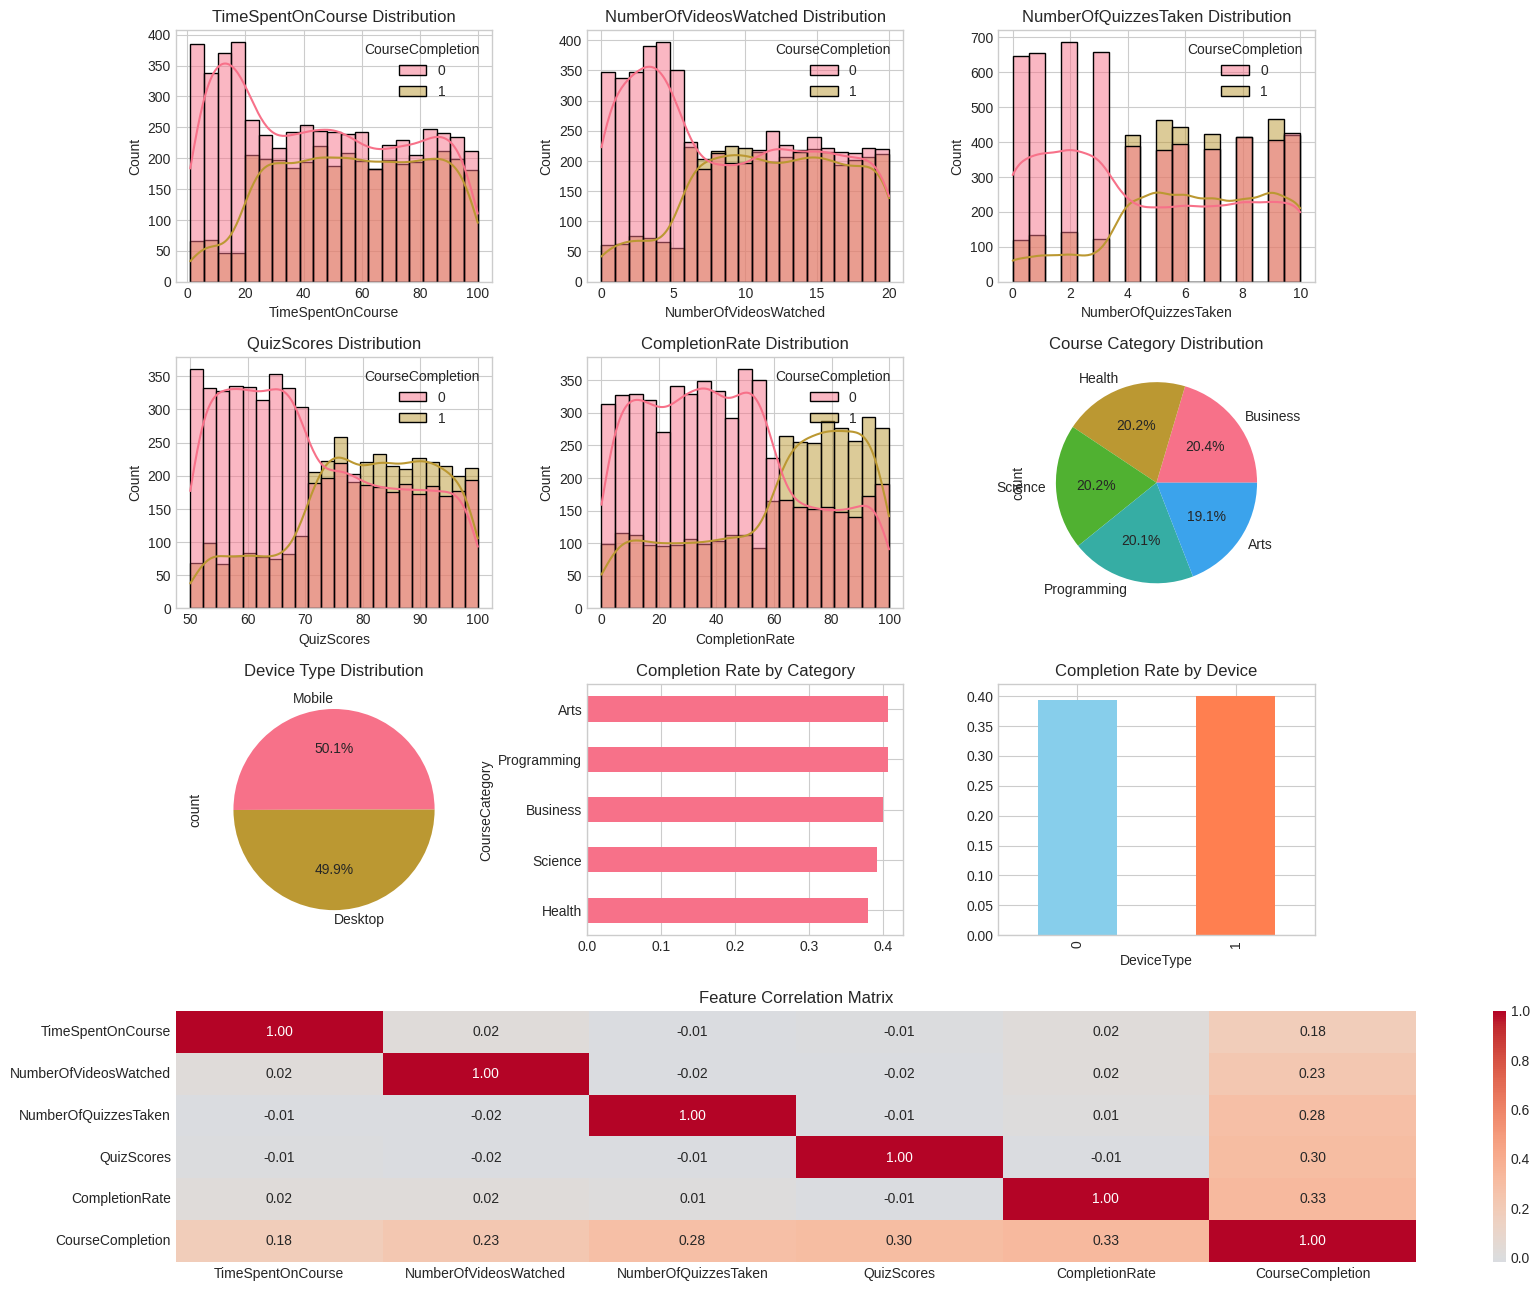

In [17]:
print(f"Dataset Shape: {df.shape}")
print(f"Target Distribution:\n{df['CourseCompletion'].value_counts()}")
print(f"Target Balance: {df['CourseCompletion'].mean():.2%} completed")

# Create figure with better layout
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# Feature distributions
numeric_features = ['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken',
                    'QuizScores', 'CompletionRate']

for idx, col in enumerate(numeric_features):
    ax = fig.add_subplot(gs[idx//3, idx%3])
    sns.histplot(data=df, x=col, hue='CourseCompletion', kde=True, ax=ax)
    ax.set_title(f'{col} Distribution')

# Course category distribution
ax = fig.add_subplot(gs[1, 2])
df['CourseCategory'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title('Course Category Distribution')

# Device type distribution
ax = fig.add_subplot(gs[2, 0])
df['DeviceType'].value_counts().plot.pie(labels=['Mobile', 'Desktop'], autopct='%1.1f%%', ax=ax)
ax.set_title('Device Type Distribution')

# Completion by category
ax = fig.add_subplot(gs[2, 1])
completion_by_category = df.groupby('CourseCategory')['CourseCompletion'].mean().sort_values()
completion_by_category.plot.barh(ax=ax)
ax.set_title('Completion Rate by Category')

# Completion by device
ax = fig.add_subplot(gs[2, 2])
completion_by_device = df.groupby('DeviceType')['CourseCompletion'].mean()
completion_by_device.plot.bar(ax=ax, color=['skyblue', 'coral'])
ax.set_title('Completion Rate by Device')

# Correlation matrix
ax = fig.add_subplot(gs[3, :])
corr_matrix = df[numeric_features + ['CourseCompletion']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Feature Correlation Matrix')

plt.savefig('eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 3: Feature Engineering
